# Partitioning and processing a dynamic optimization problem

* Construction of dynamic optimization problem

In [1]:
using Plasmo, PlasmoPlots

In [2]:
function create_dynamic_problem()
    T = 100 # number of time points
    d = sin.(1:T) # disturbance vector

    # create an OptiGraph
    graph = Plasmo.OptiGraph()

    # Add nodes for states and controls
    Plasmo.@optinode(graph, state[1:T])
    Plasmo.@optinode(graph, control[1:T-1])
    
    # Add state variables
    for node in state
        Plasmo.@variable(node, x)
        Plasmo.@constraint(node, x >= 0)
        Plasmo.@objective(node, Min, x^2)
    end
    # Add control variables
    for node in control
        Plasmo.@variable(node, u)
        Plasmo.@constraint(node, u >= -1000)
        Plasmo.@objective(node, Min, u^2)
    end

    # dynamic coupling
    Plasmo.@linkconstraint(graph, [i = 1:T-1], state[i+1][:x] == state[i][:x] + control[i][:u] + d[i])

    # initial condition
    n1 = state[1]
    Plasmo.@constraint(n1, n1[:x] == 0)
    return graph
end

create_dynamic_problem (generic function with 1 method)

In [3]:
graph = create_dynamic_problem()

      OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes:   199            (199)
      OptiEdges:    99             (99)
LinkConstraints:    99             (99)
 sub-OptiGraphs:     0              (0)

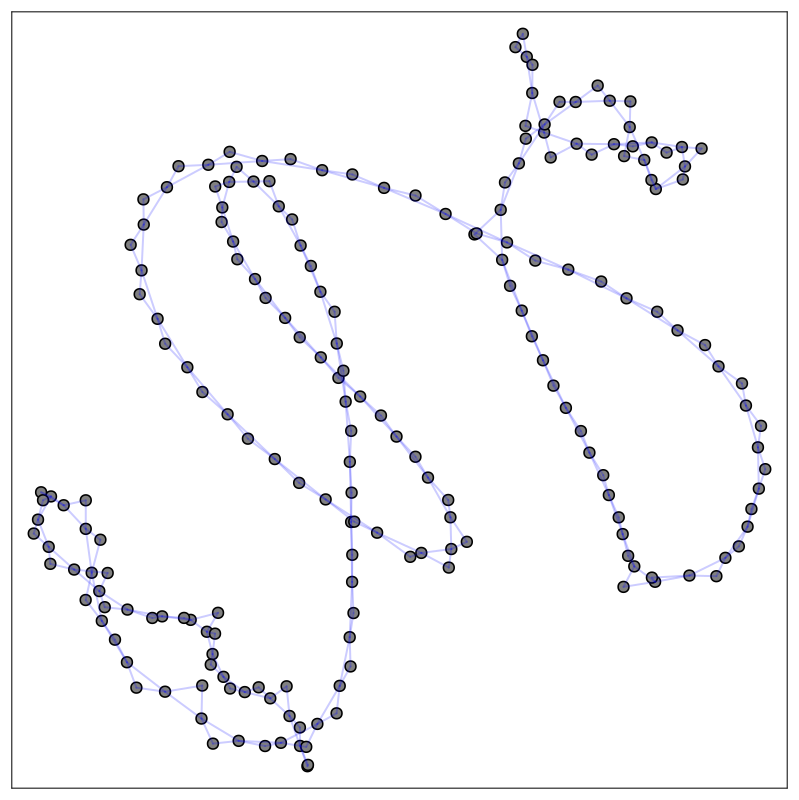

In [4]:
# plot resulting structure
plt_graph4 = PlasmoPlots.layout_plot(graph, layout_options=Dict(:tol=>0.1,:C=>2,:K=>4,:iterations=>500),linealpha=0.2,markersize=6)

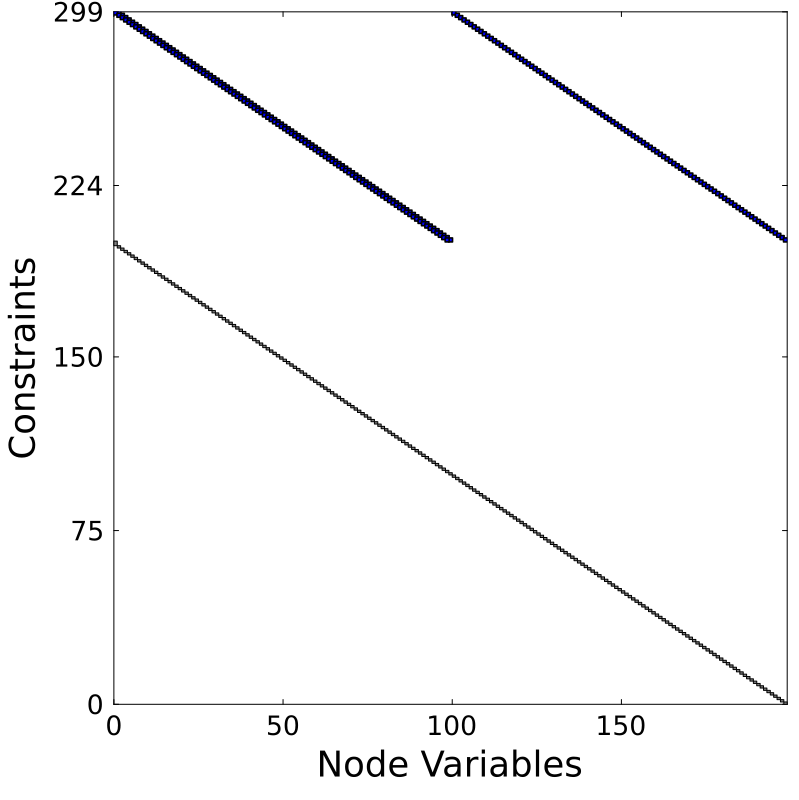

In [5]:
plt_matrix4 = PlasmoPlots.matrix_plot(graph,markersize=2)

* Partitioning, Aggregation, and Expansion

In [8]:
# import KaHyPar to perform hypergraph partitioning
using Plasmo, PlasmoPlots
using KaHyPar

In [7]:
# create graph
graph = create_dynamic_problem()

      OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes:   199            (199)
      OptiEdges:    99             (99)
LinkConstraints:    99             (99)
 sub-OptiGraphs:     0              (0)

In [12]:
# Define function to perform partitioning
function partition_dynamic_problem!(g::OptiGraph)
    hypergraph, projection_map = Plasmo.hyper_graph(g)
    node_vector = KaHyPar.partition(hypergraph, 8, configuration=:connectivity, imbalance=0.01)
    partition = Plasmo.Partition(node_vector, projection_map)
    Plasmo.apply_partition!(g, partition)
end

partition_dynamic_problem! (generic function with 1 method)

In [13]:
# Perform partitioning
partition_dynamic_problem!(graph)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
+                    _  __     _   _       ____                               + 
+                   | |/ /__ _| | | |_   _|  _ \ __ _ _ __                    + 
+                   | ' // _` | |_| | | | | |_) / _` | '__|                   + 
+                   | . \ (_| |  _  | |_| |  __/ (_| | |                      + 
+                   |_|\_\__,_|_| |_|\__, |_|   \__,_|_|                      + 
+                                    |___/                                    + 
+                 Karlsruhe Hypergraph Partitioning Framework                 + 
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 
*******************************************************************************
*                            Partitioning Context                             *
*******************************************************************************
Partitioning Parameters:
  Hype

In [19]:
# plot partitioned graph
plt_graph1 = PlasmoPlots.layout_plot(graph, layout_options=Dict(:tol=>0.01, :iterations=>500),linealpha=0.2,markersize=6,subgraph_colors=true);

plt_matrix1 = PlasmoPlots.matrix_plot(graph,subgraph_colors=true);

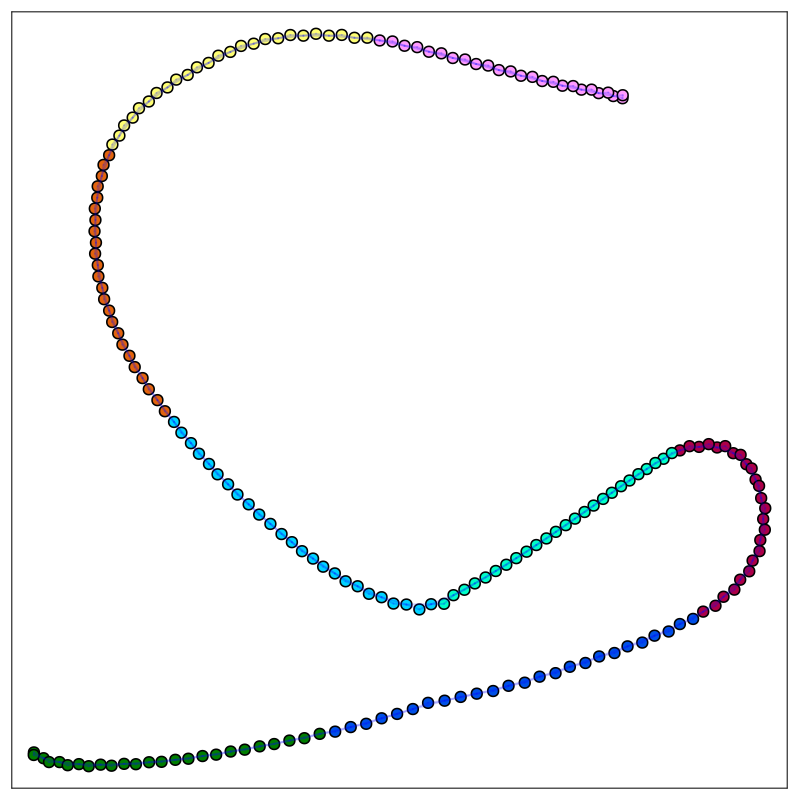

In [24]:
plt_graph1

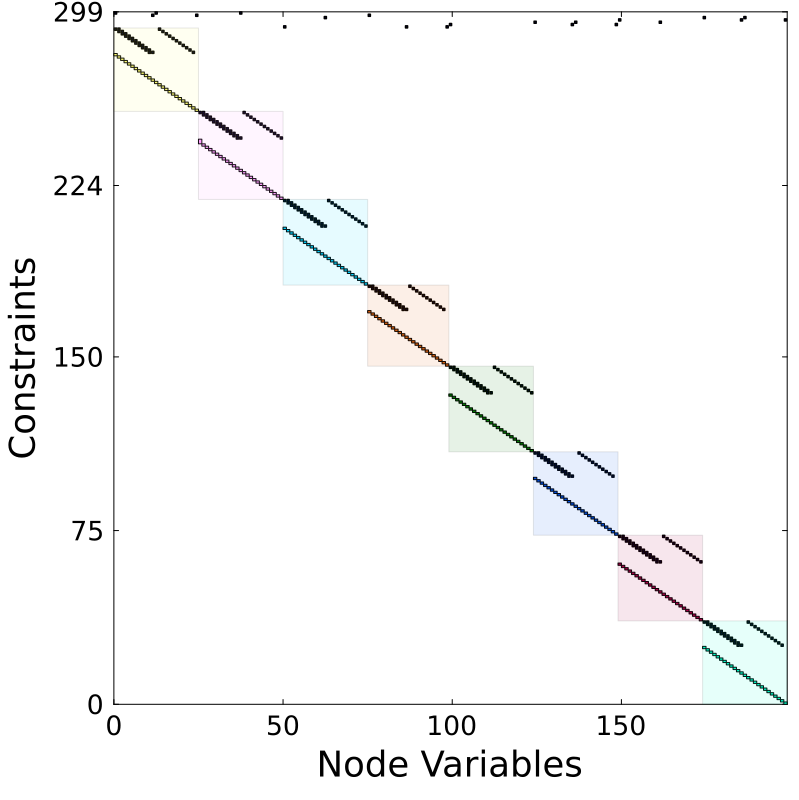

In [25]:
plt_matrix1

In [64]:
# create aggregated optigraph and plot it.
aggregated_graph, ref_map = Plasmo.aggregate(graph, 0)

Aggregating OptiGraph with a maximum subgraph depth of 0


(      OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes:     8              (8)
      OptiEdges:     7              (7)
LinkConstraints:     7              (7)
 sub-OptiGraphs:     0              (0), Plasmo.AggregateMap(Dict{VariableRef, VariableRef}(state[59][:x] => state[59][:x], control[50][:u] => control[50][:u], control[87][:u] => control[87][:u], state[75][:x] => state[75][:x], control[84][:u] => control[84][:u], control[70][:u] => control[70][:u], control[14][:u] => control[14][:u], control[99][:u] => control[99][:u], control[75][:u] => control[75][:u], state[96][:x] => state[96][:x]…), Dict{ConstraintRef, ConstraintRef}(control[40][:u] ≥ -1000 => control[40][:u] ≥ -1000, control[68][:u] ≥ -1000 => control[68][:u] ≥ -1000, state[39][:x] ≥ 0 => state[39][:x] ≥ 0, state[81][:x] ≥ 0 => state[81][:x] ≥ 0, control[83][:u] ≥ -1000 => control[83][:u] ≥ -1000, control[99][:u] ≥ -1000 => control[99][:u] ≥ -10

In [68]:
# plot partitioned graph
plt_graph2 = PlasmoPlots.layout_plot(aggregated_graph, layout_options=Dict(:tol=>0.01, :iterations=>10),node_labels=true,markersize=30,labelsize=20,node_colors=true);
# plt_graph2 = PlasmoPlots.layout_plot(aggregated_graph, layout_options=Dict(:tol=>0.01, :iterations=>500),linealpha=0.2,markersize=6,subgraph_colors=true);

plt_matrix2 = PlasmoPlots.matrix_plot(aggregated_graph,node_labels=true,node_colors=true);

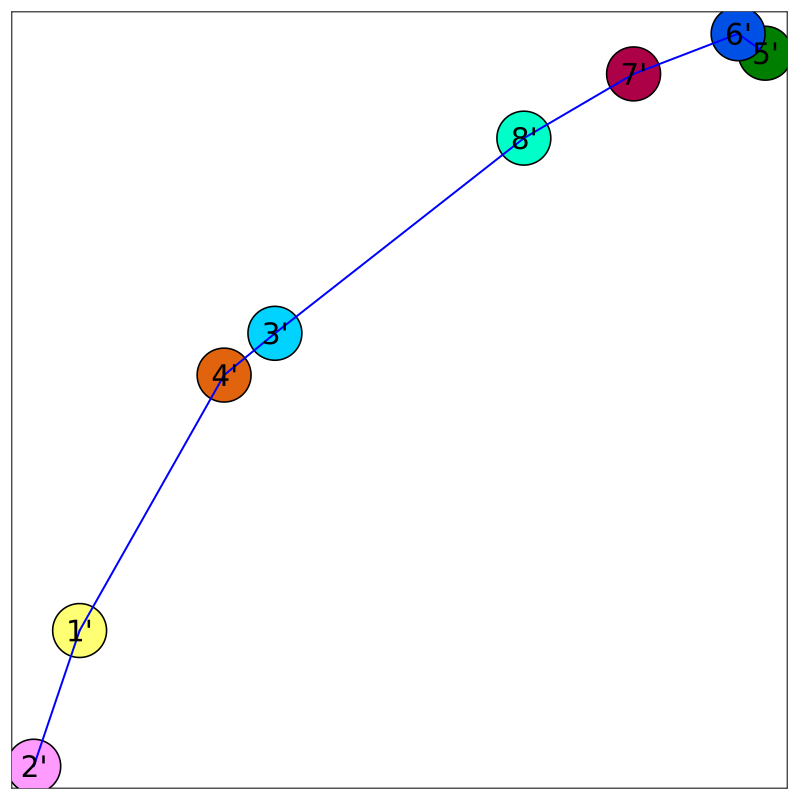

In [69]:
plt_graph2

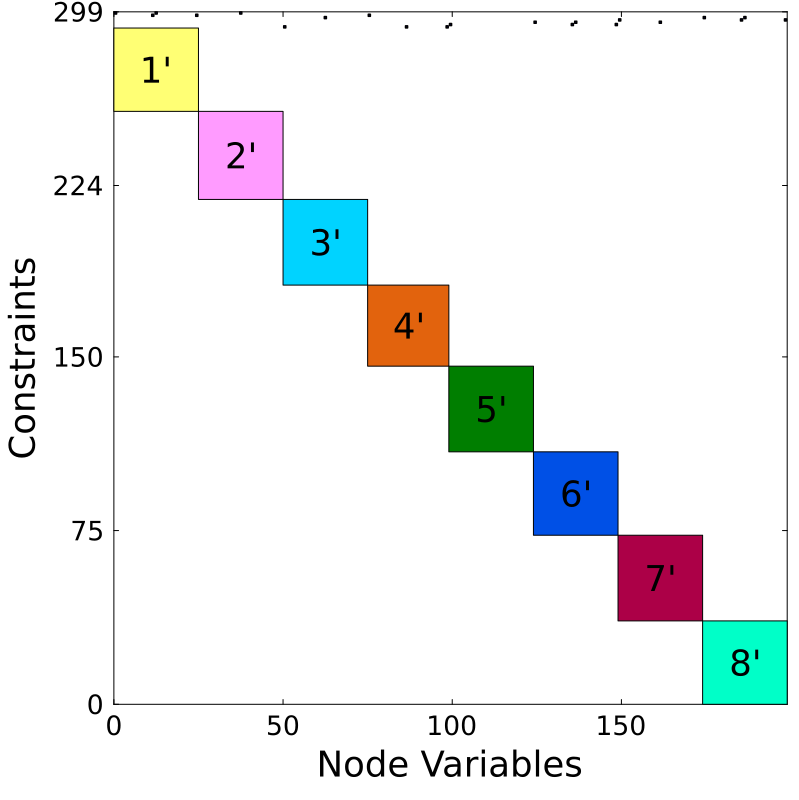

In [70]:
plt_matrix2

In [71]:
# create expanded subgraphs and plot it
subgraphs = Plasmo.getsubgraphs(graph)
expanded_subgraphs = Plasmo.expand.(graph, subgraphs, 2)

8-element Vector{OptiGraph}:
       OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes:    31             (31)
      OptiEdges:    15             (15)
LinkConstraints:    15             (15)
 sub-OptiGraphs:     0              (0)
       OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes:    29             (29)
      OptiEdges:    14             (14)
LinkConstraints:    14             (14)
 sub-OptiGraphs:     0              (0)
       OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes:    33             (33)
      OptiEdges:    16             (16)
LinkConstraints:    16             (16)
 sub-OptiGraphs:     0              (0)
       OptiGraph: # elements (including subgraphs)
-------------------------------------------------------------------
      OptiNodes

In [72]:
plt_graph3 = PlasmoPlots.layout_plot(graph,expanded_subgraphs,layout_options=Dict(:tol=>0.01,:iterations=>1000),markersize=6,linealpha=0.2);
plt_matrix3 = PlasmoPlots.matrix_plot(graph,expanded_subgraphs);

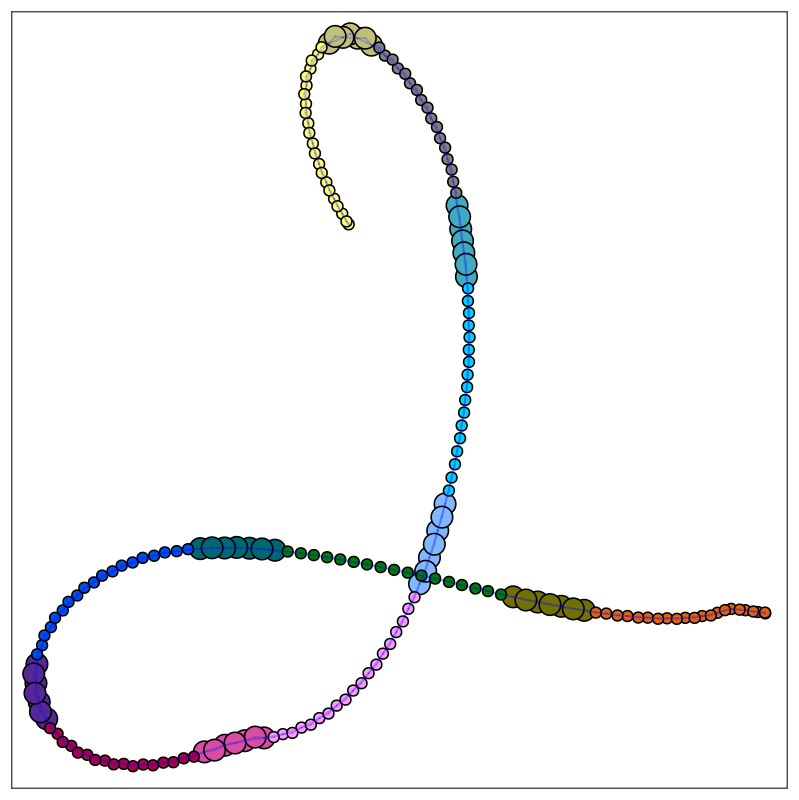

In [73]:
plt_graph3

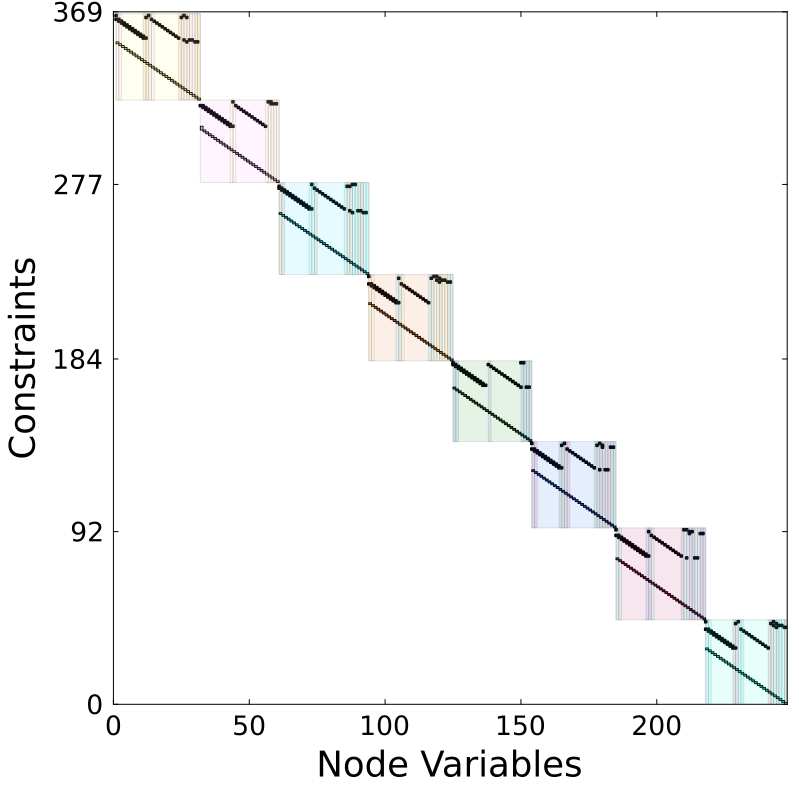

In [74]:
plt_matrix3